# Big Data Platforms

## Instacart Market Basket Analysis using PySpark

DataSet:
https://www.instacart.com/datasets/grocery-shopping-2017

Reference: 
https://databricks.com/blog/2018/09/18/simplify-market-basket-analysis-using-fp-growth-on-databricks.html

### Data Model

`orders` (3.4m rows, 206k users):
* `order_id`: order identifier
* `user_id`: customer identifier
* `eval_set`: which evaluation set this order belongs in (see `SET` described below)
* `order_number`: the order sequence number for this user (1 = first, n = nth)
* `order_dow`: the day of the week the order was placed on
* `order_hour_of_day`: the hour of the day the order was placed on
* `days_since_prior`: days since the last order, capped at 30 (with NAs for `order_number` = 1)

`products` (50k rows):
* `product_id`: product identifier
* `product_name`: name of the product
* `aisle_id`: foreign key
* `department_id`: foreign key

`aisles` (134 rows):
* `aisle_id`: aisle identifier
* `aisle`: the name of the aisle

`departments` (21 rows):
* `department_id`: department identifier
* `department`: the name of the department

`order_products__SET` (30m+ rows):
* `order_id`: foreign key
* `product_id`: foreign key
* `add_to_cart_order`: order in which each product was added to cart
* `reordered`: 1 if this product has been ordered by this user in the past, 0 otherwise

where `SET` is one of the four following evaluation sets (`eval_set` in `orders`):
* `"prior"`: orders prior to that users most recent order (~3.2m orders)
* `"train"`: training data supplied to participants (~131k orders)
* `"test"`: test data reserved for machine learning competitions (~75k orders)

In [22]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('MarketBasketAnalysis').getOrCreate()
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

%matplotlib inline

### Import Data

In [2]:
# Import Data
aisles = spark.read.csv("T:\\courses\\BigData\\data\\instacart\\aisles.csv", header=True, inferSchema=True)
departments = spark.read.csv("T:\\courses\\BigData\\data\\instacart\\departments.csv", header=True, inferSchema=True)
order_products_prior = spark.read.csv("T:\\courses\\BigData\\data\\instacart\\order_products__prior.csv", header=True, inferSchema=True)
order_products_train = spark.read.csv("T:\\courses\\BigData\\data\\instacart\\order_products__train.csv", header=True, inferSchema=True)
orders = spark.read.csv("T:\\courses\\BigData\\data\\instacart\\orders.csv", header=True, inferSchema=True)
products = spark.read.csv("T:\\courses\\BigData\\data\\instacart\\products.csv", header=True, inferSchema=True)

# Create Temporary Tables
aisles.createOrReplaceTempView("aisles")
departments.createOrReplaceTempView("departments")
order_products_prior.createOrReplaceTempView("order_products_prior")
order_products_train.createOrReplaceTempView("order_products_train")
orders.createOrReplaceTempView("orders")
products.createOrReplaceTempView("products")

## Exploratory Data Analysis

Now that you have created DataFrames, you can perform exploratory data analysis using Spark SQL.  The following queries showcase some of the quick insight you can gain from the Instacart dataset.


### Orders by Day of Week

Sunday is the most popular day for the total number of orders while Thursday has the least number of orders.

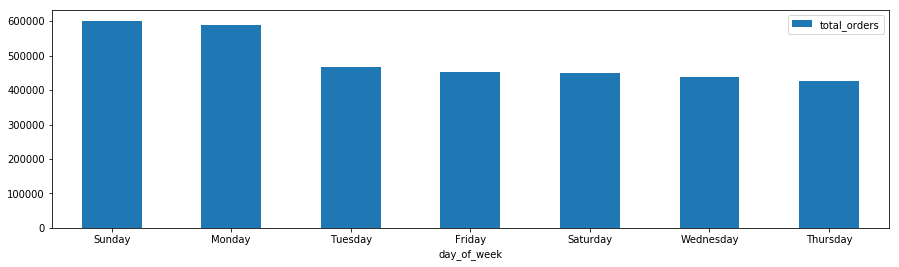

In [34]:
obw = spark.sql('''select 
  count(order_id) as total_orders, 
  (case 
     when order_dow = '0' then 'Sunday'
     when order_dow = '1' then 'Monday'
     when order_dow = '2' then 'Tuesday'
     when order_dow = '3' then 'Wednesday'
     when order_dow = '4' then 'Thursday'
     when order_dow = '5' then 'Friday'
     when order_dow = '6' then 'Saturday'              
   end) as day_of_week 
  from orders  
 group by order_dow 
 order by total_orders desc''')

obw.toPandas().plot(y='total_orders' , x ='day_of_week', kind='bar', figsize=(15,4), rot=0)

### Orders by Hour

When breaking down the hours typically people are ordering their groceries from Instacart during business working hours with highest number orders at 10:00am.

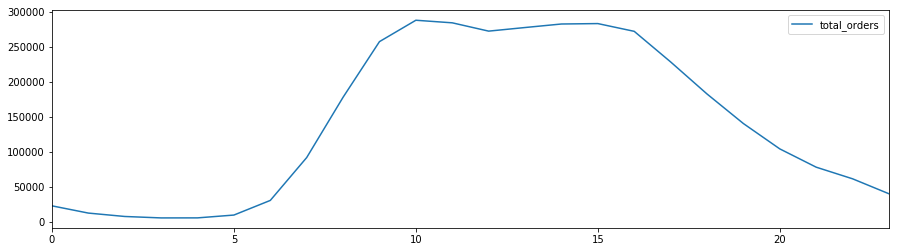

In [36]:
obh = spark.sql('''select 
  count(order_id) as total_orders, 
  order_hour_of_day as hour 
  from orders 
 group by order_hour_of_day 
 order by order_hour_of_day''')

obh.toPandas().plot(y='total_orders', figsize=(15,4))

### Top 10 Popular Items

In [5]:
spark.sql('''select count(opp.order_id) as orders, p.product_name as popular_product
  from order_products_prior opp, products p
 where p.product_id = opp.product_id 
 group by popular_product 
 order by orders desc 
 limit 10''').show()

+------+--------------------+
|orders|     popular_product|
+------+--------------------+
|472565|              Banana|
|379450|Bag of Organic Ba...|
|264683|Organic Strawberries|
|241921|Organic Baby Spinach|
|213584|Organic Hass Avocado|
|176815|     Organic Avocado|
|152657|         Large Lemon|
|142951|        Strawberries|
|140627|               Limes|
|137905|  Organic Whole Milk|
+------+--------------------+



### Understand shelf space by department

As we dive deeper into our market basket analysis, we can gain insight on the number of products by department to understand how much shelf space is being used.

In [6]:
spark.sql('''select d.department, count(distinct p.product_id) as products
  from products p
    inner join departments d
      on d.department_id = p.department_id
 group by d.department
 order by products desc
 limit 10''').show()

+---------------+--------+
|     department|products|
+---------------+--------+
|  personal care|    6563|
|         snacks|    6264|
|         pantry|    5371|
|      beverages|    4365|
|         frozen|    4007|
|     dairy eggs|    3449|
|      household|    3084|
|   canned goods|    2092|
|dry goods pasta|    1858|
|        produce|    1684|
+---------------+--------+



### Max Products By Department

In [7]:
spark.sql('''select countbydept.*
  from (
  -- from product table, let's count number of records per dept
  -- and then sort it by count (highest to lowest) 
  select department_id, count(1) as counter
    from products
   group by department_id
   order by counter asc 
  ) as maxcount
inner join (
  -- let's repeat the exercise, but this time let's join
  -- products and departments tables to get a full list of dept and 
  -- prod count
  select
    d.department_id,
    d.department,
    count(1) as products
    from departments d
      inner join products p
         on p.department_id = d.department_id
   group by d.department_id, d.department 
   order by products desc
  ) countbydept 
  -- combine the two queries's results by matching the product count
  on countbydept.products = maxcount.counter''').show()

+-------------+---------------+--------+
|department_id|     department|products|
+-------------+---------------+--------+
|           11|  personal care|    6563|
|           19|         snacks|    6264|
|           13|         pantry|    5371|
|            7|      beverages|    4365|
|            1|         frozen|    4007|
|           16|     dairy eggs|    3449|
|           17|      household|    3084|
|           15|   canned goods|    2092|
|            9|dry goods pasta|    1858|
|            4|        produce|    1684|
|            3|         bakery|    1516|
|           20|           deli|    1322|
|           21|        missing|    1258|
|            6|  international|    1139|
|           14|      breakfast|    1115|
|           18|         babies|    1081|
|            5|        alcohol|    1054|
|            8|           pets|     972|
|           12|   meat seafood|     907|
|            2|          other|     548|
+-------------+---------------+--------+
only showing top

## Association Mining

### Organize Shopping Basket

To prepare our data for downstream processing, we will organize our data by shopping basket. That is, each row of our DataFrame represents an order_id with each items column containing an array of items.

In [8]:
# Organize the by shopping basket
from pyspark.sql.functions import collect_set, col, count
rawData = spark.sql("select p.product_name, o.order_id from products p inner join order_products_train o where o.product_id = p.product_id")
baskets = rawData.groupBy('order_id').agg(collect_set('product_name').alias('items'))
baskets.createOrReplaceTempView('baskets')
baskets.show()

+--------+--------------------+
|order_id|               items|
+--------+--------------------+
|    1342|[Raw Shrimp, Seed...|
|    1591|[Cracked Wheat, S...|
|    4519|[Beet Apple Carro...|
|    4935|             [Vodka]|
|    6357|[Globe Eggplant, ...|
|   10362|[Organic Baby Spi...|
|   19204|[Reduced Fat Crac...|
|   29601|[Organic Red Onio...|
|   31035|[Organic Cripps P...|
|   40011|[Organic Baby Spi...|
|   46266|[Uncured Beef Hot...|
|   51607|[Donut House Choc...|
|   58797|[Concentrated But...|
|   61793|[Raspberries, Gre...|
|   67089|[Original Tofurky...|
|   70863|[Extra Hold Non-A...|
|   88674|[Organic Coconut ...|
|   91937|[No. 485 Gin, Mon...|
|   92317|[Red Vine Tomato,...|
|   99621|[Organic Baby Aru...|
+--------+--------------------+
only showing top 20 rows



### Frequent Itemsets

The FP-Growth (Frequent Pattern growth) algorithm is currently one of the fastest approaches to frequent item set mining. FP-Growth is an improvement of apriori designed to eliminate some of the heavy bottlenecks in apriori. The algorithm was planned with the bennefits of mapReduce taken into account, so it works well with any distributed system focused on mapReduce. FP-Growth simplifies all the problems present in apriori by using a structure called an FP-Tree.

Given a dataset of transactions, the first step of FP-growth is to calculate item frequencies and identify frequent items. Different from Apriori-like algorithms designed for the same purpose, the second step of FP-growth uses a suffix tree (FP-tree) structure to encode transactions without generating candidate sets explicitly, which are usually expensive to generate.

In [37]:
from pyspark.ml.fpm import FPGrowth

#set the minimum thresholds for support and confidence
fpGrowth = FPGrowth(itemsCol="items", minSupport=0.001, minConfidence=0)

model = fpGrowth.fit(baskets)

#Calculate frequent itemsets
mostPopularItemInABasket = model.freqItemsets
mostPopularItemInABasket.createOrReplaceTempView("mostPopularItemInABasket")

# Display frequent itemsets.
model.freqItemsets.show(truncate =False)

+-----------------------------------------------------------------+-----+
|items                                                            |freq |
+-----------------------------------------------------------------+-----+
|[Organic Tomato Basil Pasta Sauce]                               |772  |
|[Organic Tomato Basil Pasta Sauce, Bag of Organic Bananas]       |175  |
|[Organic Tomato Basil Pasta Sauce, Organic Baby Spinach]         |144  |
|[Organic Tomato Basil Pasta Sauce, Banana]                       |179  |
|[Organic Spinach Bunch]                                          |475  |
|[Whole Milk Ricotta Cheese]                                      |347  |
|[Medium Salsa Roja]                                              |275  |
|[Ground Buffalo]                                                 |231  |
|[Tonic Water]                                                    |194  |
|[Original Coconut Milk Beverage]                                 |173  |
|[Low-Fat Strawberry Banana on the Bot

In [18]:
#only show item groups larger than 2
spark.sql('''select items, freq from mostPopularItemInABasket 
          where size(items) > 2 order by freq desc limit 20''').show(truncate =False)

+--------------------------------------------------------------------+----+
|items                                                               |freq|
+--------------------------------------------------------------------+----+
|[Organic Hass Avocado, Organic Strawberries, Bag of Organic Bananas]|710 |
|[Organic Raspberries, Organic Strawberries, Bag of Organic Bananas] |649 |
|[Organic Baby Spinach, Organic Strawberries, Bag of Organic Bananas]|587 |
|[Organic Raspberries, Organic Hass Avocado, Bag of Organic Bananas] |531 |
|[Organic Hass Avocado, Organic Baby Spinach, Bag of Organic Bananas]|497 |
|[Organic Avocado, Organic Baby Spinach, Banana]                     |484 |
|[Organic Avocado, Large Lemon, Banana]                              |477 |
|[Limes, Large Lemon, Banana]                                        |452 |
|[Organic Cucumber, Organic Strawberries, Bag of Organic Bananas]    |424 |
|[Limes, Organic Avocado, Large Lemon]                               |389 |
|[Organic Ra

### Association Rules

In [10]:
model.associationRules.show(25, truncate=False)

+----------------------------------------------+-------------------------------------+-------------------+
|antecedent                                    |consequent                           |confidence         |
+----------------------------------------------+-------------------------------------+-------------------+
|[Broccoli Crown, Organic Strawberries]        |[Banana]                             |0.3690773067331671 |
|[Sugar Snap Peas]                             |[Bag of Organic Bananas]             |0.2207001522070015 |
|[Organic Red Onion, Organic Strawberries]     |[Bag of Organic Bananas]             |0.34673366834170855|
|[Organic Red Onion, Organic Strawberries]     |[Organic Baby Spinach]               |0.22780569514237856|
|[85% Lean Ground Beef]                        |[Banana]                             |0.235202492211838  |
|[Organic Small Bunch Celery, Organic Cucumber]|[Bag of Organic Bananas]             |0.36633663366336633|
|[Organic Zucchini, Limes]           

In [11]:
#sort by confidence
model.associationRules.orderBy("confidence", ascending=False).show(25, truncate=False)

+------------------------------------------------------------------+------------------------+-------------------+
|antecedent                                                        |consequent              |confidence         |
+------------------------------------------------------------------+------------------------+-------------------+
|[Organic Raspberries, Organic Hass Avocado, Organic Strawberries] |[Bag of Organic Bananas]|0.5984251968503937 |
|[Organic Cucumber, Organic Hass Avocado, Organic Strawberries]    |[Bag of Organic Bananas]|0.546875           |
|[Organic Kiwi, Organic Hass Avocado]                              |[Bag of Organic Bananas]|0.5459770114942529 |
|[Organic Navel Orange, Organic Raspberries]                       |[Bag of Organic Bananas]|0.5412186379928315 |
|[Yellow Onions, Strawberries]                                     |[Banana]                |0.5357142857142857 |
|[Organic Whole String Cheese, Organic Hass Avocado]               |[Bag of Organic Bana

### Predictions

In [12]:
# transform examines the input items against all the association rules and summarize the
# consequents as prediction
model.transform(baskets).show()

+--------+--------------------+--------------------+
|order_id|               items|          prediction|
+--------+--------------------+--------------------+
|    1342|[Raw Shrimp, Seed...|[Organic Tomato B...|
|    1591|[Cracked Wheat, S...|[Bag of Organic B...|
|    4519|[Beet Apple Carro...|                  []|
|    4935|             [Vodka]|                  []|
|    6357|[Globe Eggplant, ...|[Organic Tomato B...|
|   10362|[Organic Baby Spi...|[Organic Strawber...|
|   19204|[Reduced Fat Crac...|[Bag of Organic B...|
|   29601|[Organic Red Onio...|[Organic Tomato B...|
|   31035|[Organic Cripps P...|[Organic Tomato B...|
|   40011|[Organic Baby Spi...|[Organic Tomato B...|
|   46266|[Uncured Beef Hot...|[Organic Tomato B...|
|   51607|[Donut House Choc...|                  []|
|   58797|[Concentrated But...|[Organic Tomato B...|
|   61793|[Raspberries, Gre...|[Hass Avocados, S...|
|   67089|[Original Tofurky...|[Organic Tomato B...|
|   70863|[Extra Hold Non-A...|[Limes, Organic